# Классификация: превышает ли SI медианное значение

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler

In [3]:
# Загрузка и подготовка
df = pd.read_excel("Данные_для_курсовои_Классическое_МО.xlsx")
df = df.drop(columns=["Unnamed: 0"], errors='ignore')
df = df.dropna(subset=["SI"])

# Создание бинарной метки: SI > медианы
threshold = df["SI"].median()
df["SI_class"] = (df["SI"] > threshold).astype(int)

# Удаляем SI, IC50, CC50 и метку
X = df.drop(columns=["SI", "IC50, mM", "CC50, mM", "SI_class"], errors='ignore')
y = df["SI_class"]

# Классификация: бинаризация по медиане SI
threshold = y.median()
y_class = (y > threshold).astype(int)

# Заполнение NaN и нормализация
X = X.fillna(X.median(numeric_only=True))
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [4]:
# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_class, test_size=0.2, random_state=42)

# Модели
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM (RBF)": SVC(probability=True),
    "KNN": KNeighborsClassifier()
}

# Оценка
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan

    results.append({
        "Model": name,
        "Accuracy": acc,
        "F1-score": f1,
        "ROC AUC": auc
    })

# Вывод результатов
results_df = pd.DataFrame(results).sort_values(by="F1-score", ascending=False)
print(results_df)

                 Model  Accuracy  F1-score   ROC AUC
4                  KNN  0.681592  0.666667  0.715950
1        Random Forest  0.681592  0.652174  0.732726
2    Gradient Boosting  0.676617  0.644809  0.709976
3            SVM (RBF)  0.676617  0.632768  0.706292
0  Logistic Regression  0.656716  0.627027  0.673736


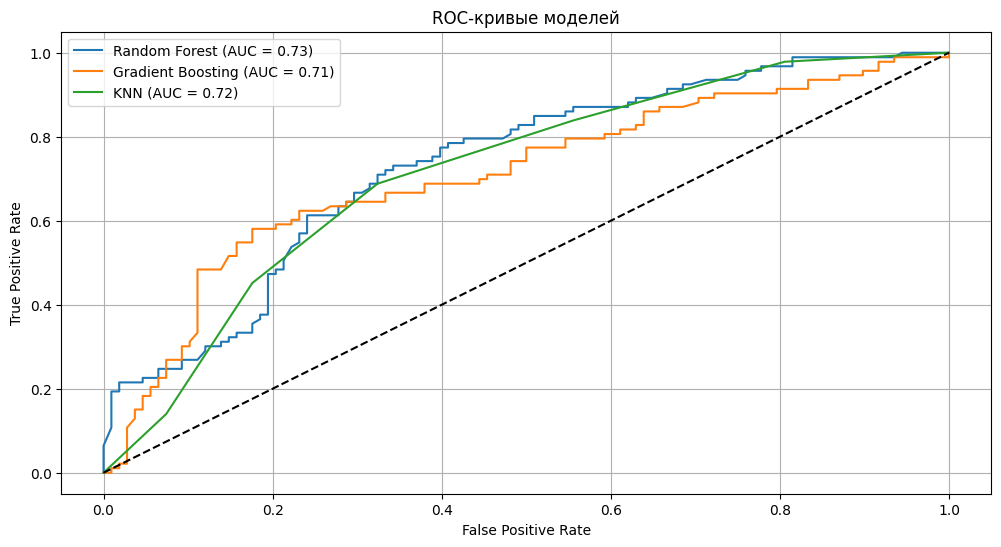

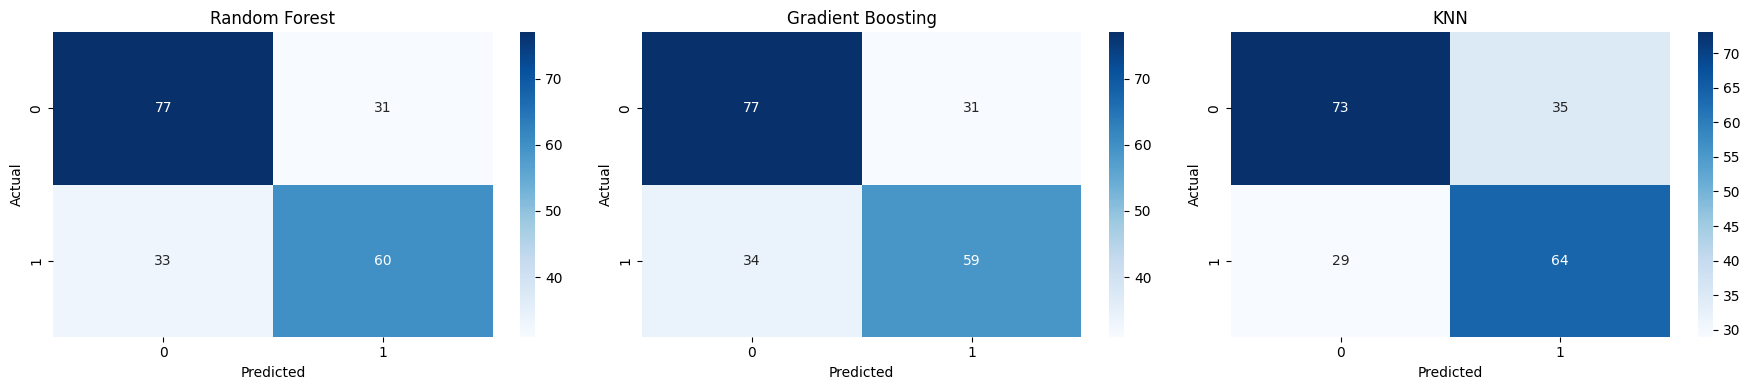

In [5]:
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    classification_report,
    RocCurveDisplay,
)

# Модели
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "KNN": KNeighborsClassifier()
}

results = {}
plt.figure(figsize=(12, 6))
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Метрики
    cm = confusion_matrix(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    report = classification_report(y_test, y_pred, output_dict=True)

    results[name] = {
        "conf_matrix": cm,
        "fpr": fpr,
        "tpr": tpr,
        "roc_auc": roc_auc,
        "report": report
    }

    # ROC-кривая
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC-кривые моделей")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

# Матрицы ошибок
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
for i, (name, res) in enumerate(results.items()):
    sns.heatmap(res["conf_matrix"], annot=True, fmt="d", cmap="Blues", ax=axes[i])
    axes[i].set_title(name)
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")
plt.tight_layout()
plt.show()

# Таблица метрик
metrics_table = pd.DataFrame({
    name: {
        "Accuracy": res["report"]["accuracy"],
        "Precision": res["report"]["1"]["precision"],
        "Recall": res["report"]["1"]["recall"],
        "F1-Score": res["report"]["1"]["f1-score"],
        "AUC": res["roc_auc"]
    }
    for name, res in results.items()
}).T.round(3)

Провожу кросс-валидацию и усреднить AUC/F1-score по фолдам.

In [9]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, roc_auc_score, f1_score

# Стратифицированная кросс-валидация
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Модели
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "KNN": KNeighborsClassifier()
}

results = []

for name, model in models.items():
    # AUC: работает только если predict_proba доступна
    auc_scores = cross_val_score(model, X_scaled, y_class, cv=cv, scoring='roc_auc')

    # F1: через make_scorer
    f1_scores = cross_val_score(model, X_scaled, y_class, cv=cv, scoring=make_scorer(f1_score))

    results.append({
        "Model": name,
        "AUC_mean": auc_scores.mean(),
        "AUC_std": auc_scores.std(),
        "F1_mean": f1_scores.mean(),
        "F1_std": f1_scores.std()
    })

# Результаты
results_df = pd.DataFrame(results).set_index("Model").round(3)
display(results_df)

,AUC_mean,AUC_std,F1_mean,F1_std
Model,,,,
Random Forest,0.712,0.023,0.650,0.034
Gradient Boosting,0.705,0.019,0.651,0.041
KNN,0.715,0.028,0.656,0.043


# Обучаю базовую модель Gradient Boosting

In [10]:
# Обучение базовой модели
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [11]:
# Предсказания
y_pred = knn.predict(X_test)
y_prob = knn.predict_proba(X_test)[:, 1]

# Метрики
report = classification_report(y_test, y_pred, output_dict=True)
auc_score = roc_auc_score(y_test, y_prob)
conf_matrix = confusion_matrix(y_test, y_pred)

report["AUC"] = auc_score
report["conf_matrix"] = conf_matrix
report

{'0': {'precision': 0.7156862745098039,
  'recall': 0.6759259259259259,
  'f1-score': 0.6952380952380952,
  'support': 108.0},
 '1': {'precision': 0.6464646464646465,
  'recall': 0.6881720430107527,
  'f1-score': 0.6666666666666666,
  'support': 93.0},
 'accuracy': 0.681592039800995,
 'macro avg': {'precision': 0.6810754604872252,
  'recall': 0.6820489844683393,
  'f1-score': 0.680952380952381,
  'support': 201.0},
 'weighted avg': {'precision': 0.6836583570560745,
  'recall': 0.681592039800995,
  'f1-score': 0.6820184790334044,
  'support': 201.0},
 'AUC': np.float64(0.7159498207885304),
 'conf_matrix': array([[73, 35],
        [29, 64]])}

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Параметры для подбора
param_grid = {
    'n_neighbors': range(3, 21, 2),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn = KNeighborsClassifier()

grid = GridSearchCV(knn, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print("Лучшие параметры:", grid.best_params_)
print("Лучшая AUC:", grid.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Лучшие параметры: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'uniform'}
Лучшая AUC: 0.7209587010400018


In [13]:
# Извлекаем лучшие параметры
best_params = grid.best_params_

# Повторное обучение на лучших параметрах
final_model = KNeighborsClassifier(**best_params)
final_model.fit(X_train, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=7)

In [15]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = final_model.predict(X_test)
y_prob = final_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       0.66      0.69      0.68       108
           1       0.62      0.59      0.61        93

    accuracy                           0.65       201
   macro avg       0.64      0.64      0.64       201
weighted avg       0.65      0.65      0.65       201

AUC: 0.7132118677817603


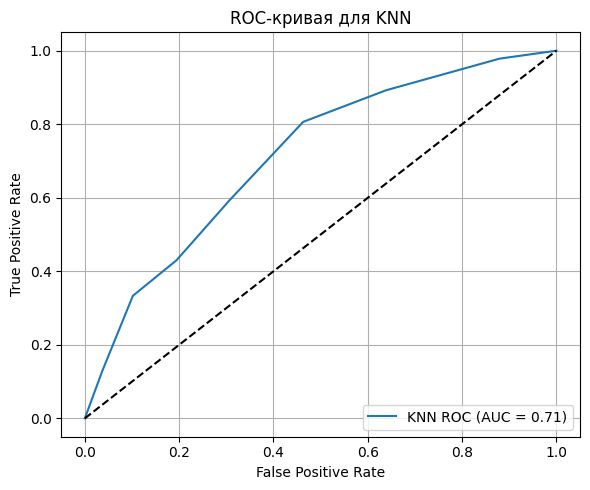

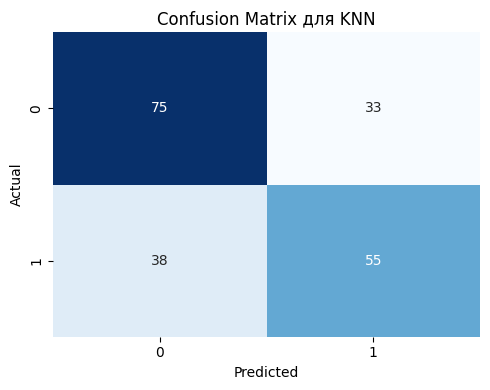

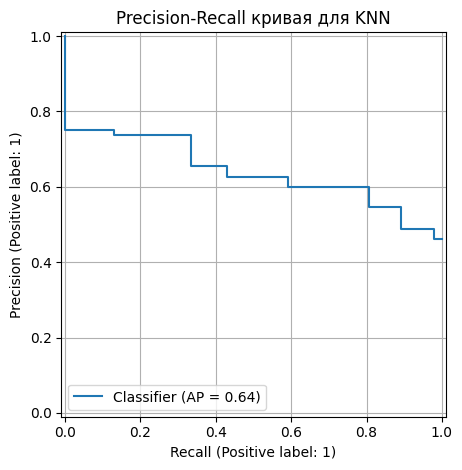

In [16]:
# ROC-кривая
y_prob = final_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'KNN ROC (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая для KNN")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# Матрица ошибок
cm = confusion_matrix(y_test, final_model.predict(X_test))
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix для KNN")
plt.tight_layout()
plt.show()

# Precision-Recall кривая
PrecisionRecallDisplay.from_predictions(y_test, y_prob)
plt.title("Precision-Recall кривая для KNN")
plt.grid(True)
plt.tight_layout()
plt.show()